<a href="https://colab.research.google.com/github/MuhammadArifRizkiPohan/ComputerVisionScratch/blob/main/Prediction_Human_Emotion_with_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I try to classify human face emotions from kaggle, but just use 2 classes because this only to practice
* angry
* fear
use model Restnet50

In [6]:
!nvidia-smi

Mon Nov 24 12:30:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!unzip /content/Human_emotion_dataset.zip

Archive:  /content/Human_emotion_dataset.zip
   creating: Human_emotion_dataset/
   creating: Human_emotion_dataset/test/
   creating: Human_emotion_dataset/test/Angry/
  inflating: Human_emotion_dataset/test/Angry/278.png  
  inflating: Human_emotion_dataset/test/Angry/280.png  
  inflating: Human_emotion_dataset/test/Angry/294.png  
  inflating: Human_emotion_dataset/test/Angry/295.png  
  inflating: Human_emotion_dataset/test/Angry/298.png  
  inflating: Human_emotion_dataset/test/Angry/307.png  
  inflating: Human_emotion_dataset/test/Angry/323.png  
  inflating: Human_emotion_dataset/test/Angry/338.png  
  inflating: Human_emotion_dataset/test/Angry/342.png  
  inflating: Human_emotion_dataset/test/Angry/353.png  
  inflating: Human_emotion_dataset/test/Angry/355.png  
  inflating: Human_emotion_dataset/test/Angry/360.png  
  inflating: Human_emotion_dataset/test/Angry/368.png  
  inflating: Human_emotion_dataset/test/Angry/369.png  
  inflating: Human_emotion_dataset/test/Angry/3

In [8]:
#Resize image to input for restnet 224,224
Image_size=[224,224]

In [9]:
size = [224,224] + [3]
size

[224, 224, 3]

In [10]:
train_path = '/content/Human_emotion_dataset/train'
valid_path = '/content/Human_emotion_dataset/test'

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

In [13]:
vgg16 = VGG16(input_shape=Image_size + [3],  weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Freeze the weights of the VGG16 base model so they are not updated during training
for layer in vgg16.layers:
  layer.trainable = False

In [15]:
for layer in vgg16.layers:
  print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [16]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
folders = glob('/content/Human_emotion_dataset/*')
folders

['/content/Human_emotion_dataset/train', '/content/Human_emotion_dataset/test']

In [21]:
num_of_class = len(folders)
num_of_class

2

In [22]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_of_class, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 264 images belonging to 2 classes.


In [29]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 110 images belonging to 2 classes.


In [30]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4995 - loss: 3.0091 - val_accuracy: 0.5000 - val_loss: 1.2069
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.5201 - loss: 0.9264 - val_accuracy: 0.5000 - val_loss: 0.8656
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.5960 - loss: 0.6958 - val_accuracy: 0.5636 - val_loss: 0.6814
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 655ms/step - accuracy: 0.6736 - loss: 0.6107 - val_accuracy: 0.6000 - val_loss: 0.6718
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.7604 - loss: 0.5317 - val_accuracy: 0.6000 - val_loss: 0.6821
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.7912 - loss: 0.4898 - val_accuracy: 0.5909 - val_loss: 0.7021
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.7687 - loss: 0.4795 - val_accuracy: 0.6273 - val_loss: 0.6503
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.8363 - loss: 0.4570 - val_accuracy: 0.5455 - val_loss: 0

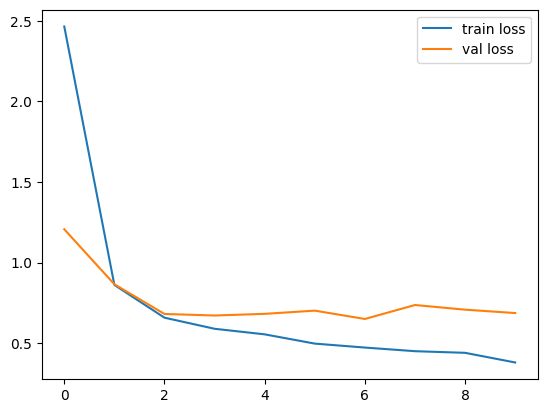

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

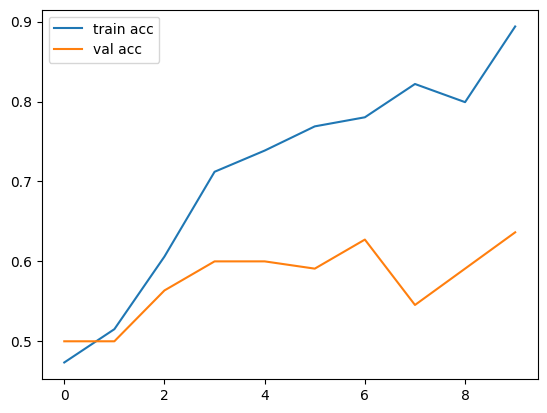

<Figure size 640x480 with 0 Axes>

In [32]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [33]:
model.evaluate(test_set)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6108 - loss: 0.7126


[0.6870710253715515, 0.6363636255264282]

In [34]:
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [35]:
model = load_model("model_vgg16.h5")

In [36]:
from tensorflow.keras.preprocessing import image

In [37]:
img = ('/content/764.png')

In [38]:
img=image.load_img(img,target_size=(224,224))


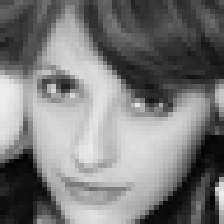

In [39]:
img


In [40]:
x=image.img_to_array(img)
x


array([[[ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        ...,
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.]],

       [[ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        ...,
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.]],

       [[ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        [ 72.,  72.,  72.],
        ...,
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.],
        [ 82.,  82.,  82.]],

       ...,

       [[ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        ...,
        [159., 159., 159.],
        [159., 159., 159.],
        [159., 159., 159.]],

       [[ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        ...,
        [159., 159., 159.],
        [159., 159., 159.],
        [159., 159., 159.]],

       [[ 26.,  26.,  26.],
        [ 26.,  26.,  26.],
        [ 26.,  

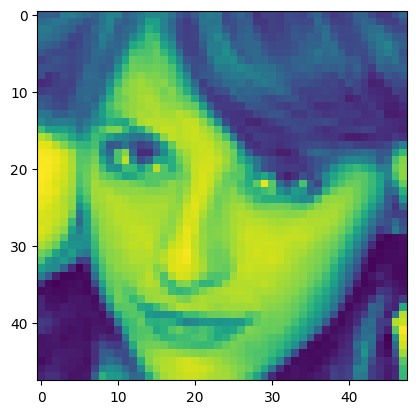

In [41]:
Z = plt.imread('/content/764.png')
plt.imshow(Z)

In [42]:
x.shape

(224, 224, 3)

In [43]:
x=x/255


In [44]:
from keras.applications.vgg16 import preprocess_input
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)

In [45]:
output = model.predict(img_data)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.99403363, 0.00596637]], dtype=float32)

In [46]:
result = np.argmax(output, axis=1)
result

array([0])

In [47]:
if result[0] == 0:
    prediction = 'Angry'
    print(prediction)
else:
    prediction = 'Fear'
    print(prediction)

Angry


In [48]:
# Get the class labels from the training set
class_labels = list(training_set.class_indices.keys())
print("Class labels:", class_labels)

Class labels: ['angry', 'fear']


Let's define a list of image paths you want to predict. For demonstration, I will pick a few from your test set.

In [53]:
import os

# Example list of image paths to predict
image_paths_to_predict = [
    '/content/1163.png',
    '/content/743.png'

]


print(f"Number of images to predict: {len(image_paths_to_predict)}")
print("Image paths:", image_paths_to_predict)

Number of images to predict: 2
Image paths: ['/content/1163.png', '/content/743.png']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

--- Predictions ---
Image: 1163.png -> Predicted Emotion: fear (Confidence: 1.0000)


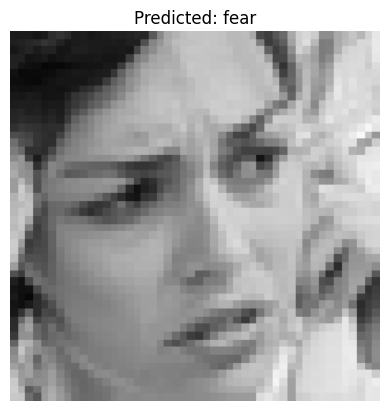

Image: 743.png -> Predicted Emotion: fear (Confidence: 1.0000)


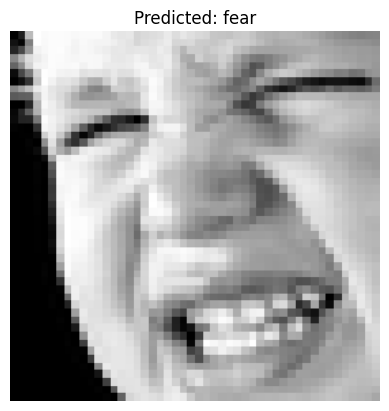

In [54]:
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def predict_multiple_images(image_paths, model, class_labels, target_size=(224, 224)):
    processed_images = []
    original_images = []

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=target_size)
        original_images.append(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) # Add batch dimension
        x = preprocess_input(x) # Apply VGG16 preprocessing
        processed_images.append(x)

    if not processed_images:
        print("No images to predict.")
        return

    # Concatenate all preprocessed images into a single batch
    batch_img_data = np.vstack(processed_images)

    # Make predictions
    predictions = model.predict(batch_img_data)

    # Interpret results
    predicted_classes = np.argmax(predictions, axis=1)

    print("\n--- Predictions ---")
    for i, (img_path, pred_idx) in enumerate(zip(image_paths, predicted_classes)):
        prediction_label = class_labels[pred_idx]
        print(f"Image: {os.path.basename(img_path)} -> Predicted Emotion: {prediction_label} (Confidence: {predictions[i][pred_idx]:.4f})")

        # Optional: Display image and prediction
        plt.imshow(original_images[i])
        plt.title(f"Predicted: {prediction_label}")
        plt.axis('off')
        plt.show()

# Call the function with your list of image paths
predict_multiple_images(image_paths_to_predict, model, class_labels)